### Perturber Harper model and associated quantum system 


In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import mpmath as mpmath

# %matplotlib notebook 
%matplotlib inline 


Our classical Hamiltonian 
\begin{align}
 H(\phi,p,\tau) = a(1- \cos (p-b)) - \epsilon \cos(\phi) - \mu \cos(\phi - \nu t) - \mu' \cos(\phi + \tau)
 \end{align}
$$ {\bf y} = [\phi,p]$$
Hamilton's equations give 
\begin{align}
 \frac{d{\bf y}}{d\tau} &= [\dot \phi, \dot p]  = [\partial_p H, -\partial_\phi H] \\
      & = [a \sin (p-b), -\epsilon \sin(\phi) - \mu \sin(\phi - \nu t) - \mu' \sin(\phi + \tau)] 
\end{align}

Here all quantities are unitless.  


In [70]:
# routines for classical system integration 

# set up equations of motion
# y = [phi,p]  dimension 2
# H(phi,p,tau) = a(1 - cos (p-b)) - epsilon*cos phi - mu*cos(phi - nu t) - mup*cos(phi + tau)
# dy/dt = [\dot phi, \dot p]
#       = [a\sin p, -epsilon*sin(phi) - mu*sin(phi - nu*t) - mup*sin(phi + tau) ]
#There should be three islands, one at p=0 and the others at sin p=1/a
#the widths of these are set by \sqrt{2 epsilon/a}, \sqrt{2 mu/a},  \sqrt{2 mup/a}

# dy/dtau = func(y,tau), needed for integrator!
# note that y[0] = phi and y[1] = p
def cfunc(y,tau,a,b,epsilon,mu,mup):
        return [a*np.sin(y[1]-b),\
                -epsilon*np.sin(y[0]) - mu*np.sin(y[0] - tau) - mup*np.sin(y[0] + tau)]

def H_classical(p,phi,tau,a,b,epsilon,mu,mup):
    #phi = y[0]; p = y[1]
    return a*(1.0 - np.cos(p-b)) - epsilon*np.cos(phi)\
        - mu*np.cos(phi-tau) - mup*np.cos(phi+tau)


In [72]:
# integrate at a period, the forced pendulum 
# arguments:
#   y0 is initial conditions, 
#   npoints is number of points we want
#   a,epsilon, mu, mup are parameters of the Hamiltonian model
#
#   integrate every 2 pi period, npoints returned including initial condition 
# returns: phi,p arrays of integrated points 
# this particular routin does all times at once by sending a set of times to the integrator
# if we want to take p modulo 2pi we would have to integrate slowly to find when trajectories
# cross pi or -pi
twopi = 2.0*np.pi
def givepoints_arr(y0,npoints,a,b,epsilon,mu,mup):
    # set up time array, every 2pi/nu so for period of perturbation
    step  = 2.0*np.pi
    stop = step*npoints
    time  = np.arange(0.0,stop,step)  # time array for outputs  goes from 0 to stop-step 
    #                              with increment step, does not reach stop. 
    # do the integration
    y = odeint(cfunc, y0, time, args=(a,b,epsilon,mu,mup))
    #y2 = odeint(func, y0, time, Dfun=jacobian, args=(epsilon,mu,nu))  # if you want to use a jacobian
    phi_arr = np.squeeze(y[:,0])  # is an array of phi at different times
    p_arr = np.squeeze(y[:,1])    # is an array of momenta at different times
    
    phi_arr  = phi_arr%twopi  # so that phi in [0:2pi]
    p_arr = p_arr%twopi  # so that p is in [0,2pi]
    
    ii = phi_arr >np.pi
    phi_arr[ii]-= twopi # now phi is in [-pi,pi]
    ii = p_arr >np.pi
    p_arr[ii]-= twopi   # now p is in [-pi,pi]
    
    return phi_arr,p_arr 
       
# integrate points and plot them on axis    ax   
def givepoints(y0,npoints,a,b,epsilon,mu,mup,marker,ax):
    phi_arr,p_arr=givepoints_arr(y0,npoints,a,b,epsilon,mu,mup)
    ax.plot(phi_arr,p_arr,marker,markersize=0.5) # plot it
    
colorlist = ['black','blue','green','magenta','red','orange','gold','blueviolet','springgreen','dodgerblue']

# randomly choose an initial condition, integrate and plot in axis ax 
# arguments:
#    npoints: numbers of points to plot 
#    pmin, pmax constrain the vertical width of randomly chosen initial conditions 
#    epsilon,mu,mup: parameters for the dynamical model 
#    ax  the axis on which to plot points 
def rand_give_points(npoints,a,b,epsilon,mu,mup,pmin,pmax,ax):
    phi = np.random.uniform(low=-np.pi,high=np.pi)
    p = np.random.uniform(low=pmin,high=pmax)
    y0 = [phi,p]
    phi_arr,p_arr=givepoints_arr(y0,npoints,a,b,epsilon,mu,mup)
    i = np.random.randint(low=0,high =len(colorlist))
    ax.scatter(phi_arr,p_arr,s=1,edgecolor='none',facecolor=colorlist[i],lw=1)

# make a figure with norb orbits 
def mkfig_cl(norb,npoints,a,b,epsilon,mu,mup,froot):
    # set up display
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200) 
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel('p')
    ax.set_aspect('equal')

    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])

    parm_label = r'$a$={:.1f},'.format(a)
    parm_label += r'$\epsilon$={:.2f},'.format(epsilon)
    parm_label += r'$\mu$={:.2f},'.format(mu)
    muprime = r'$\mu$' + '\''
    parm_label += muprime
    parm_label += r'={:.2f},'.format(mup)
    #parm_label += r'$\nu$={:.0f}'.format(nu)
    ax.text(0,3.4,parm_label,ha='center',va='center')

    for i in range(norb):  # this many orbits 
        rand_give_points(npoints,a,b,epsilon,mu,mup,ymin,ymax,ax)
    if (len(froot)>2):
        ofile = froot + '_class.png'
        plt.savefig(ofile,dpi=300)

    

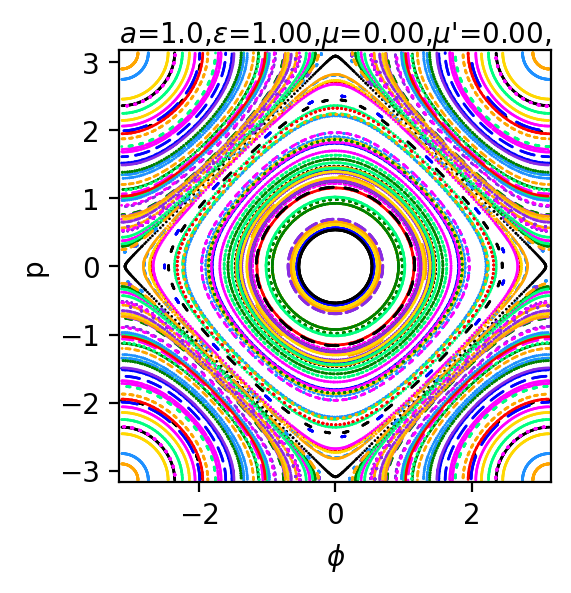

In [74]:
# choose parameters
a=1.;   epsilon=1.; b=0
mu=0.0; mup=mu
npoints=500 # points in each orbit!
norb = 100  # number of orbits

froot = ''
mkfig_cl(norb,npoints,a,b,epsilon,mu,mup,froot)


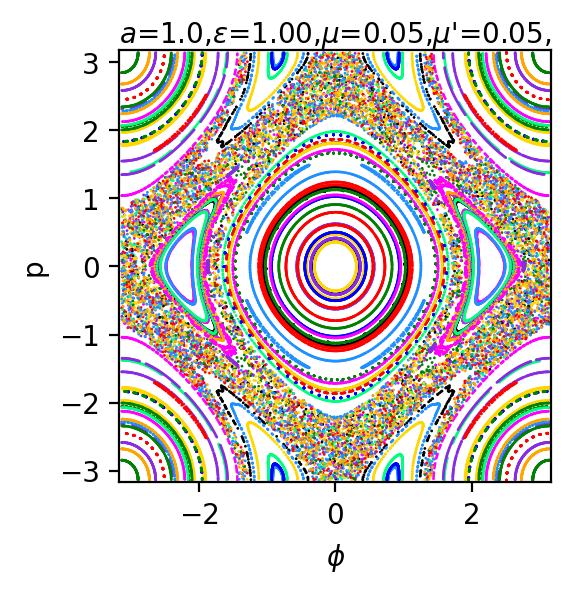

In [19]:
# choose parameters
a=1.;  b=0
epsilon=1.
mu=0.05; mup=mu
npoints=500 # points in each orbit!
norb = 100  # number of orbits

froot = 'ff1'
mkfig_cl(norb,npoints,a,b,epsilon,mu,mup,froot)

### discrete quantum phase space 

Let's make a displacement operator
$${\hat D} ( k,l) = \omega^{-kl/2} {\hat Z}^k {\hat  X}^l $$
with 
$$ \hat Z = \sum_{n} \omega^n |n\rangle \langle n| = \sum_k | k+1\rangle_F \langle k|_F$$ 
$$ \hat X = \sum_n | n+1 \rangle \langle n |  = \sum_k \omega^{-k} | k\rangle_F \langle k|_F  $$
where 
$$ \omega = e^{2 \pi i/N}$$ 

$\hat X$ generates displacement in the regular basis and so is like a momentum op. 

$\hat Z$ generates displacement in the Fourier basis and so is like a position op?

If we index $k,l$  this would be $y,x$ for a n array as shown in imshow

A function that is a unimodal eigenfunction of the discrete Fourier transform with eigenvalue 1; 
$$|\tilde \eta\rangle = b \sum_{m=0}^{N-1}  \vartheta_3 \left( \frac{\pi m}{N}, e^{-\pi/N} \right)  
| m \rangle $$
where $\vartheta_3$ is a Jacobi function and $b$ serves to normalize the function. 
See 
https://en.wikipedia.org/wiki/Discrete_Fourier_transform 
which we can compute using https://mpmath.org/doc/current/functions/elliptic.html#jacobi-theta-functions


There is also a summation version
$$ |\tilde \eta \rangle \propto \sum_{m=0}^{N-1} \sum_{j=-\infty}^\infty e^{-\frac{\pi}{N} (m + jN)^2}|m\rangle $$
 

We define coherent states using the displacement operator and $|\tilde\eta \rangle $; 
$$ |k,l\rangle = {\hat D} (k,l)| {\tilde \eta} \rangle$$

Compute the Hussimi function of a state vector $|\psi \rangle $ as 
$$H(k,l) = |\langle \psi | k,l\rangle |^2$$


We define the QFT as 
\begin{align}
Q_{FT} = \frac{1}{\sqrt{N} } \sum_{mn} \omega^{mn} |m \rangle \langle n|
\end{align}
and the basis 
\begin{align}
|m\rangle_F = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1}\omega^{jm} | j\rangle 
\end{align}
and this gives
\begin{align}
\langle j| m \rangle_F  = \frac{1}{\sqrt{N}}\omega^{jm}
\end{align}

In [21]:
# routines for displacement operator, coherent states and Husimi distribution 

# return Xhat as a 2d NxN complex matrix (unitary)   
def Xhat_op(N): # in regular basis 
    X = np.zeros((N,N),dtype=complex)
    for k in range(N):
        X[(k+1)%N,k] = 1.0 + 0j
    return X

# return Zhat as a 2d NxN complex matrix (unitary)  
def Zhat_op(N):  # in regular basis
    Z = np.zeros((N,N),dtype=complex)
    for k in range(N):
        omegaj = np.exp(2*np.pi*k*1j/N)
        Z[k,k] = omegaj 
    return Z

# create Dhat, the displacement operator as a function of k,l  
# returns an NxN complex matrix, is unitary 
def Displacement_op(N,k,l):
    #D = np.zeros((N,N),dtype=complex)
    omega = np.exp(2*np.pi*1j/N)
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N)
    Z = Zhat_op(N)
    Xl = np.linalg.matrix_power(X, l)
    Zk = np.linalg.matrix_power(Z, k)
    Dhat= np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
    return Dhat

# compute the eta function in two different ways (and I checked that they agree!)
# returns an N dimensional complex array (a normalized quantum state vector)
def eta_tilde_check(N):
    eta = np.zeros(N,dtype=complex)
    eta_b = np.zeros(N,dtype=complex)
    efac = np.exp(-np.pi/N)
    for m in range(N):
        eta[m] = np.real(mpmath.jtheta(3,np.pi*m/N,efac)/np.sqrt(N))
    for m in range(N):  #checking with a direct sum 
        for j in range(-2*N,2*N):
            eta_b[m] += np.exp(-np.pi/N*(m + j*N)**2)  
            # arbitrarily stopped at 2N, the sum should go to infinity 
    eta_mag = np.sqrt(np.sum(eta*np.conj(eta)))
    eta = eta/eta_mag # normalize
    eta_b_mag = np.sqrt(np.sum(eta_b*np.conj(eta_b)))
    eta_b = eta_b/eta_b_mag # normalize
    return eta,eta_b

# computes eigenfunction |\tilde eta> of the QFT 
# returns an N dimensional complex normalized statevector 
# This is a unimodal periodic thing which is peaked at index 0
def eta_tilde(N):
    eta = np.zeros(N,dtype=complex)
    efac = np.exp(-np.pi/N)
    for m in range(N):  # compute using theta function 
        eta[m] = np.real(mpmath.jtheta(3,np.pi*m/N,efac)/np.sqrt(N))
    eta_mag = np.sqrt(np.sum(eta*np.conj(eta)))
    eta = eta/eta_mag   # normalize
    return eta

# checking that eta = eta_b
#eta,eta_b = eta_tilde_check(30)
#plt.plot(eta,'ro',ms=1)
#plt.plot(eta_b,'bo',ms=5,alpha=0.2)

# check that second routine actually works
#eta =  eta_tilde(30)
#plt.plot(np.real(eta),'.')

#  Creat a coherent state from Displacement operator hat D and eigenfunction |tilde eta>
# returns an N dimensional complex normalized state vector 
def coherent_state(N,k,l):
    Dhat = Displacement_op(N,k,l)
    eta=eta_tilde(N)
    ch = np.matmul(Dhat,eta)
    return ch

# make a set of coherent states from QFT eigenfunction |tilde eta> and displacement op
# returns an N x N x N 3D complex array 
#   the matrix [k,l,:] is the coherent state |k,l>
def coh_Dkl(N):
    c_matrix = np.zeros((N,N,N),dtype=complex)
    eta=eta_tilde(N)  #only do this once
    omega = np.exp(2*np.pi*1j/N)  #only do this once
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N) # only do this once
    Z = Zhat_op(N) # only do this once
    for k in range(N):
        Zk = np.linalg.matrix_power(Z, k)
        for l in range(N):
            Xl = np.linalg.matrix_power(X, l)
            Dhat = np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
            #Dhat = Displacement_op(N,k,l)
            c_matrix[k,l,:] = np.matmul(Dhat,eta)  
            # if displacement is in p direction then p increases with l
            # and k increases in x direction 
            # note that imshow displays arrays with [j,k] with j in y direction
    return c_matrix


# make a set of coherent states from QFT eigenfunction |tilde eta> and displacement op
# returns an N x N x N 3D complex array 
#   the matrix [k,l,:] is the coherent state |k,l>
#  a more efficient version 
def coh_Dkl_b(N):
    c_matrix = np.zeros((N,N,N),dtype=complex)
    eta=eta_tilde(N)  #only do this once
    omega = np.exp(2*np.pi*1j/N)  #only do this once
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N) # only do this once
    Z = Zhat_op(N) # only do this once
    Zk = np.linalg.matrix_power(Z, 0)
    for k in range(N):
        Xl = np.linalg.matrix_power(X, 0)
        for l in range(N):
            #Xl = np.linalg.matrix_power(X, l)
            Dhat = np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
            #Dhat = Displacement_op(N,k,l)
            c_matrix[k,l,:] = np.matmul(Dhat,eta)  
            # if displacement is in p direction then p increases with l
            # and k increases in x direction 
            # note that imshow displays arrays with [j,k] with j in y direction
            Xl = np.matmul(X,Xl)
        Zk = np.matmul(Z,Zk)
    return c_matrix
   
# compute Hussimi distribution of an N dimensional state vector psi 
# in advance you have computed a set of coherent states with above
#    routine coh_Dkl(N) 
# the set of coherent states is given via the argument c_matrix 
#    c_matrix should be an NxNxN matrix 
# the routine returns an NxN real matrix which is the Hussimi function  
#   note that index order is p,x  so that y would be first index, as expected for plotting 
def Husimi(psi,c_matrix):
    N = len(psi)
    H_matrix = np.zeros((N,N))
    cshape = c_matrix.shape
    if (cshape[0] != N):
        print('c_matrix is wrong dimension')
    for k in range(N):
        for l in range(N):
            co_kl = np.squeeze(c_matrix[k,l,:])  #coherent state |k,l> -p,x
            mag = np.vdot(psi,co_kl) # dot product
            mag = np.absolute(mag) # is real 
            H_matrix[k,l] = mag**2  

    return H_matrix

In [66]:
# routines for showing eigenvalues of a unitary operator 
# also the QFT

# arguments: w an array of complex eigenvalues, assumed roots of unity
# returns: an array of normalized differences between the phases of the eigenvalues 
twopi = np.pi*2
def compute_s(w):
    phi_arr = np.angle(w) # get the phase angles in [-pi,pi] of complex numbers
    # this ignores magnitude of w if it is not on the unit circle 
    phi_arr_sort = np.sort(phi_arr)  # put in order of increasing phase
    phi_shift = np.roll(np.copy(phi_arr_sort),1)
    dphi = (phi_arr_sort - phi_shift + np.pi)%twopi - np.pi  # takes care of 2pi shift
    mu_dphi = np.mean(dphi)  # find mean value of dphi 
    sarr = dphi/mu_dphi  # this is s /<s>
    return sarr  # returns normalized phase differences 

# sort eigenvalues and eigenvectors in order of increasing phase
# eigenvectors from np.linalg.eig are in form vr[:,j]
def esort_phase(w,vr):
    phi_arr = np.angle(w) # get the phase angles in [-pi,pi] of complex numbers
    iphi = np.argsort(phi_arr) # in order of increasing phase
    wsort = w[iphi]
    vrsort = np.copy(vr)*0.0
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]
    #vrsort = vr[:,iphi]  # does this work? I think so! yes
    return wsort,vrsort

# create a probability vector for the i-th eigenvector 
# vr is an array of eigenvectors 
def get_probs(vr,i):
    v = vr[:,i]
    probi = np.real(v*np.conjugate(v)) # probability vector 
    return probi  # should be n dimensional real vector 

# fill matrices with Discrete Fourier transform, returns 2 nxn matrices
# both Q_FT and Q_FT^dagger which is the inverse 
def QFT(n):
    omega = np.exp(2*np.pi*1j/n)
    Q        = np.zeros((n,n),dtype=complex)  # QFT
    Q_dagger = np.zeros((n,n),dtype=complex) 
    for j in range(n):
        for k in range(n):
            Q[j,k] = np.power(omega,j*k)  # not 100% sure about sign here! 
            Q_dagger[j,k] = np.power(omega,-j*k)
    Q        /= np.sqrt(n)  #normalize
    Q_dagger /= np.sqrt(n)
    return Q,Q_dagger 


# plot both eigenvalues on unit circle and histogram of normalized differences between phases of eigenvalues
# and angles in a third plot
def mk_plots_circ(w,froot):
    Re_part = np.real(w)
    Im_part = np.imag(w)
    sarr = compute_s(w)
    angs = np.angle(w)
    
    fig = plt.figure(figsize=(6,2.5),dpi=150)
    plt.subplots_adjust(bottom=0.15,top=0.98,right=0.98,left=0.15,wspace=0.3,hspace=0.2)

    ax_ih=fig.add_axes([0.1,0.15,0.37,0.82])  
    junk = ax_ih.hist(sarr,bins=50)
    ax_ih.set_xlabel(r'$s/\langle s\rangle$',labelpad=0)
    ax_ih.set_ylabel('distribution',labelpad=1)

    iq = 1
    ax_iq=fig.add_axes([0.55,0.15,0.37,0.82])
    junk = ax_iq.plot(angs,'g.',ms=1)
    ax_iq.set_yticks([-np.pi, 0,np.pi], labels=[r'-$\pi$','0',r'$\pi$']) 
    ax_iq.set_ylabel('quasi energy',labelpad=1)

    ax_ic=fig.add_axes([0.68,0.19,0.32,0.32])  
    ax_ic.set_aspect('equal')
    ax_ic.plot(Re_part,Im_part,'k.',ms=1)
    ax_ic.set_xticks([])
    ax_ic.set_yticks([])
    
    if (len(froot)>2):
        ofile = froot + '_circ.png'
        plt.savefig(ofile,dpi=200)

#sim1.circ(froot + '_circ.png')

### Quantized perturbed pendulum system

$$ \frac{\hat H(\hat p,\hat \phi,\tau)}{L_0 \nu} = a \left( 1 - \cos \hat p\right) - \epsilon \cos \hat \phi  - \mu \cos (\hat \phi - \tau)  $$
Using $1- \cos p$ for kinetic energy so that the system is periodic in momentum. 

Here $\hat H$ has unit of energy and the unitless angular momentum $p = L/L_0$. 

We split $\hat H$ into a piece that depends on $\hat p$ and a piece that 
depends upon $\hat \phi$. 
\begin{align}
\hat H = L_0 \nu ( \hat A_p + \hat A_\phi(\tau))
\end{align}
with 
\begin{align}
\hat A_p &= a (1-\cos \hat p) \\
\hat B_\phi(\tau) &=  -\epsilon \cos \hat \phi  - \mu \cos (\hat \phi -  \tau)
- \mu' \cos (\hat \phi +  \tau)
\end{align}
We approximate to second order in $d\tau$ 
$$e^{(A+B)d\tau} \approx A^{d\tau/2} B^{d\tau} A^{d\tau/2}$$

We need to integrate over $\tau$ going from 0, to $2\pi$. 
We devide $2 \pi$ into $n_\tau$ pieces so that $d\tau = 2 \pi/n_\tau$. 

We create some operators 
\begin{align}
\Lambda_A &=  e^{-i \frac{L_0}{\hbar} \frac{2 \pi}{n_\tau} \hat A_p} \\
\Lambda_B(\tau) &=  e^{-i \frac{L_0}{\hbar} \frac{2 \pi}{n_\tau} \hat B_\phi(\tau) }
\end{align}

\begin{align}
U_T  = \Lambda_A^\frac{1}{2} \left(\prod_j \Lambda_B(\frac{2 \pi j}{n}) \Lambda_A \right) \Lambda_A^{-\frac{1}{2}}
\end{align}


The operator $\hat p$ is diagonal 
in the Fourier basis and $p$ has period $2 \pi$. 
To be consistent with the discrete quantum space 
$$\hat p = \sum_{m=0}^{N-1} \frac{2 \pi m}{N} |m \rangle_F \langle m|_F $$

Similarly 
$$\hat \phi = \sum_{m=0}^{N-1} \frac{2 \pi j}{N} |j \rangle \langle j| $$

If we compute $\Lambda_A$ in the Fourier basis, then in the conventional basis 
$$\Lambda_A =  Q_{FT} {\rm Diag(stuff)} Q_{FT}^{-1} $$


We use Bohr Sommerfeld quantization.  The phase space volume equals $2 \pi \hbar N$ for 
integer $N$. This means $2 \pi N\hbar = (2 \pi)^2 L_0$.  This gives 
$$\frac{L_0}{\hbar} = \frac{N}{2 \pi }$$ 

In [85]:

# compute the propagator U across tau =0 to  2 pi
# trying a somewhat more efficient way to do this!
#  arguments:
#     N      : size of discrete quantum space 
#     ntau   : how many Trotterized steps to take 
#     a,b,eps,mu,mup      : parameters of classical model, all unitless 
#  returns:  
#    Ufinal  : The propagator hat U_T  (NxN complex matrix)
#    w       : vector of eigenvalues of U in order of increasing phase
#    vr      : vector of associated eigenfunctions of U 
#        vr[:,j] is the eigenvector with eigenvalue w[j]
# note we have shifted indexing so that phi=0, p =0 is in the center of the 2d arrays
def U_prop2(N,ntau,a,b,eps,mu,mup):
    DLambda_A =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ah =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ahm =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_B =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for phi part
    U_final  =np.zeros((N,N),dtype=complex)  # final propagator
    #Efac = N**2/(4.0*np.pi*ntau)    # includes dtau , is wrong
    Efac = N/ntau    # Bohr Sommerfeld type quantization gives this
    
    dtau = 2*np.pi/ntau  # step size 
    Q_FT,Q_FT_dagger = QFT(N)  # need only be computed once
    for k in range(N):  #compute ahead of time 
        pk = 2*np.pi*k/n - np.pi  # shifted!
        DLambda_Ah[k,k] = np.exp(-0.5j*Efac*a*(1.0 - np.cos(pk-b))) #diagonal in Fourier basis
        DLambda_A[k,k]  = np.exp(  -1j*Efac*a*(1.0 - np.cos(pk-b))) 
        DLambda_Ahm[k,k]= np.exp( 0.5j*Efac*a*(1.0 - np.cos(pk-b))) 
        # these are half step and full step for the momentum part
        
    LAh     = np.matmul(Q_FT,np.matmul(DLambda_Ah ,Q_FT_dagger))  # transfer basis 
    LA      = np.matmul(Q_FT,np.matmul(DLambda_A  ,Q_FT_dagger))   
    LAh_inv = np.matmul(Q_FT,np.matmul(DLambda_Ahm,Q_FT_dagger))
    
    U_final = LAh;  #inverse half step at the beginning 
        
    for i in range(ntau): # each dtau
        tau = i*dtau  # time of propagator
        for j in range(N):
            phi = 2*np.pi*j/N - np.pi  # shifted! 
            DLambda_B[j,j] = np.exp(1j*Efac*(\
                eps*np.cos(phi)+mu*np.cos(phi-tau)+mup*np.cos(phi+tau) )) # create diagonal matrix 
            # note 1j not -1j
        U_final = np.matmul(LA,np.matmul(DLambda_B,U_final))
    U_final = np.matmul(LAh_inv,U_final)
    
    (w,vr)=np.linalg.eig(U_final)  # get eigenvalues and eigenvectors
    w_s,vr_s = esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return w_s,vr_s,U_final 
            
            

In [27]:
# compute coherent states in advance
c_matrix_100 = coh_Dkl_b(100)  # 

In [89]:
c_matrix_200 = coh_Dkl_b(200)  # takes a while

In [78]:
# compute and store Husimi distributions for all eigenfunctions
# arguments:
#    vr eigenvectors  (nxn) matrix but eigenvectors are [:,j]
#    c_matrix nxn matrix of coherent states, precomputed with Dkl_b(n)
# returns matrix of Husimi distributions
def stor_Hus(vr,c_matrix):
    vshape = vr.shape; cshape = c_matrix.shape
    n =vshape[0] 
    if (cshape[0]  != n):
        print('c_matrix wrong size')
        return 0
    Hmatrix_big = np.zeros((n,n,n))
    for k in range(n): 
        Hmatrix_big[:,:,k]= Husimi(np.squeeze(vr[:,k]),c_matrix)
    return Hmatrix_big

# show Husimi functions for all eigenfunctions
# arguments:
#  Hmatrix_big: matrix of husimi functions, precomputed
def show_Hus(Hmatrix_big,froot):
    hshape = Hmatrix_big.shape;
    n =hshape[0]
    sn = int(np.sqrt(n))
    if (n - sn*sn>0):
        sn+=1;   #increase number of square so that all states are displayed

    fig,axarr = plt.subplots(sn,sn,figsize=(5,5),sharex=True,sharey=True,dpi=200)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.1,right=0.98,top=0.98,bottom=0.1);
    axarr[0,0].set_xticks([])
    axarr[0,0].set_yticks([])
    zmax = 1/sn  # could be adjusted!!!! or an argument

    for i in range(sn):   # plots are in y direction from top to down
        for j in range(sn):  # plots in x direction from left to right
            k = i*sn + j  # incrementing horizontally first
            if (k < n):
                Hmatrix = np.squeeze(Hmatrix_big[:,:,k])
                im=axarr[i,j].imshow(Hmatrix,origin='lower',vmin=0,\
                                     vmax=zmax,cmap='terrain') # flips y direction of display
                #im=axarr[i,j].imshow(Hmatrix,vmin=0,vmax=zmax,cmap='terrain')

    if (len(froot)>2):
        ofile = froot + '_Hus.png'
        plt.savefig(ofile,dpi=200)



In [80]:
# class structure to store a specific dynamical system 
# requires c_matrix, storing coherent states to be made ahead of time
class Hsys:
    def __init__(self,n,ntau,a,b,eps,mu,mup,c_matrix):
        self.n = n
        self.ntau = ntau
        self.a = a
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup = mup
        # compute the propagator and eigenfunctions and eigenvalues
        w,vr,Up= U_prop2(n,ntau,a,b,eps,mu,mup)
        self.w = w
        self.vr = vr
        self.Up = Up
        self.c_matrix = c_matrix
        # compute Husimi distribution
        self.Hmatrix_big = stor_Hus(self.vr,c_matrix)
        
    def Hus(self,froot):   # show Husimi distribution
        show_Hus(self.Hmatrix_big,froot)  
            
    def circ(self,froot):  # show stuff about eigenvalues 
        mk_plots_circ(self.w,froot) 
        
    def classical(self,froot):  # show classical phase space 
        nu=1
        norb=100
        npoints=200
        mkfig_cl(norb,npoints,self.a,self.b,self.eps,self.mu,self.mup,froot)
          

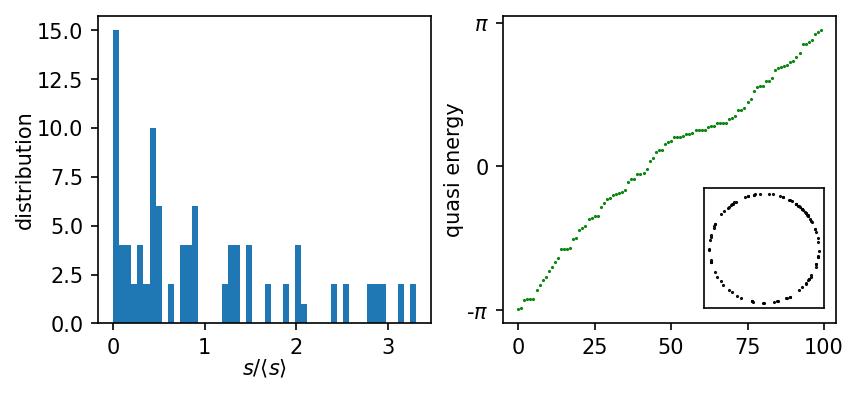

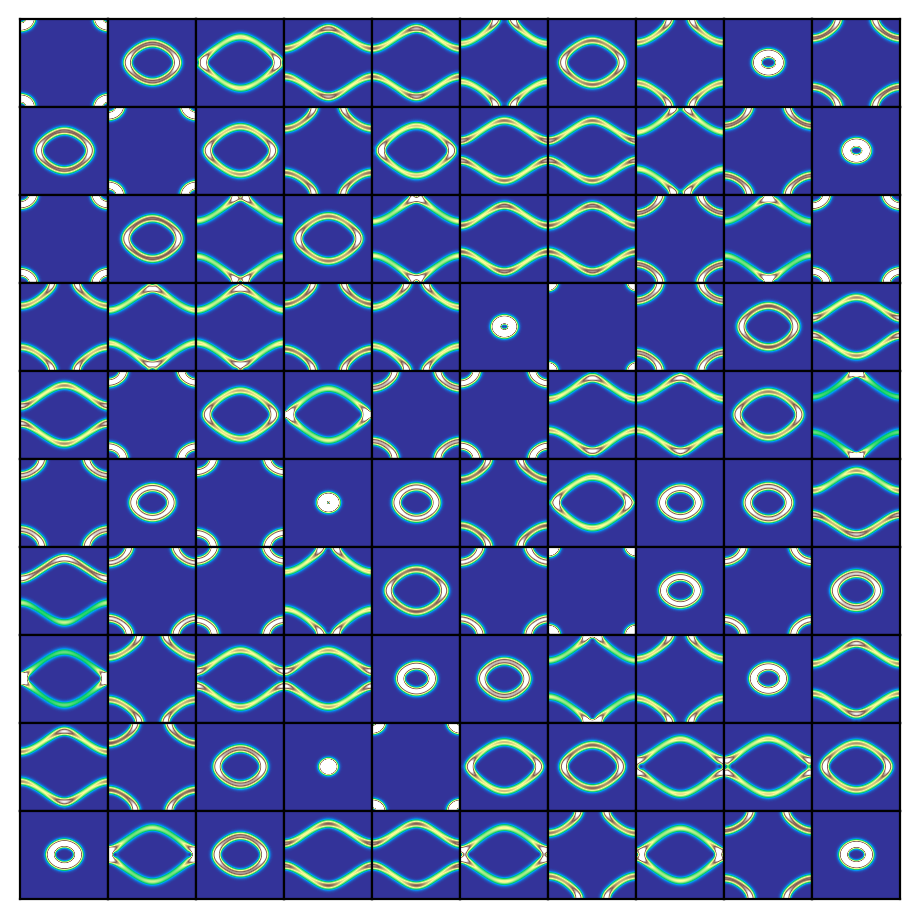

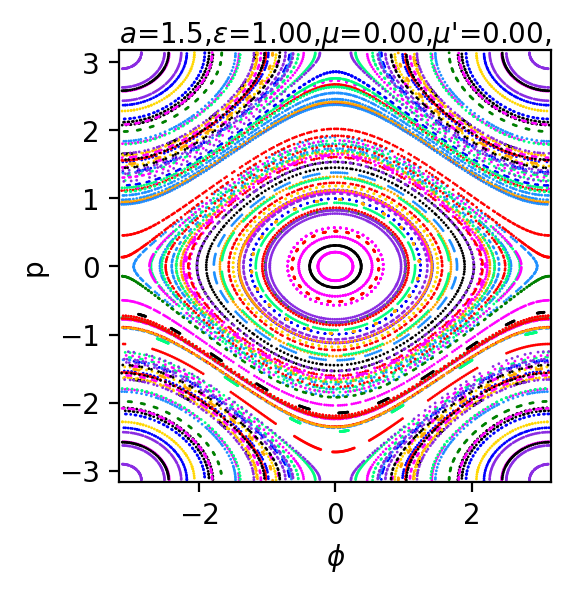

In [82]:
n=100; ntau=400;  a = 1.5; eps = 1.0; mu = 0.0; mup=0.0; b=0.0
# class computes propagator and Husimi distn
sim1 = Hsys(n,ntau,a,b,eps,mu,mup,c_matrix_100)
froot = 'vanil'
sim1.circ(froot)
sim1.Hus(froot)
sim1.classical(froot)

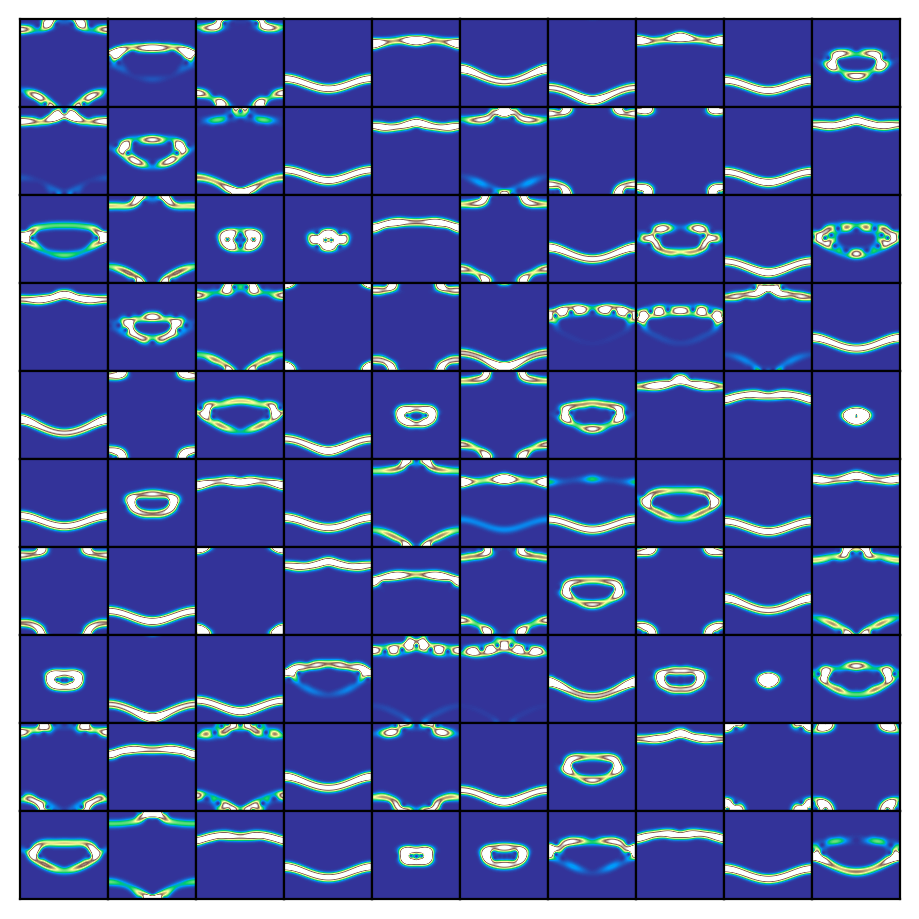

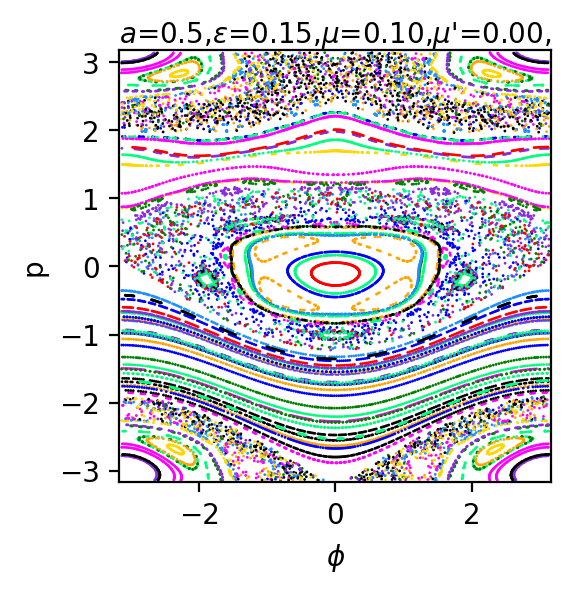

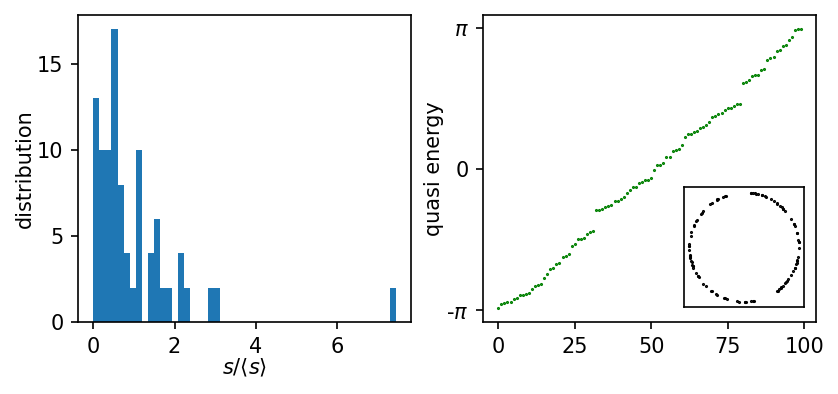

In [51]:
n=100; ntau=400; a = 0.5; eps = 0.15; mu = 0.1; mup=0.0; b=0.0
sim2= Hsys(n,ntau,a,b,eps,mu,mup,c_matrix_100) 
froot = 'ahalf'
sim2.Hus(froot)
sim2.classical(froot)
sim2.circ(froot)

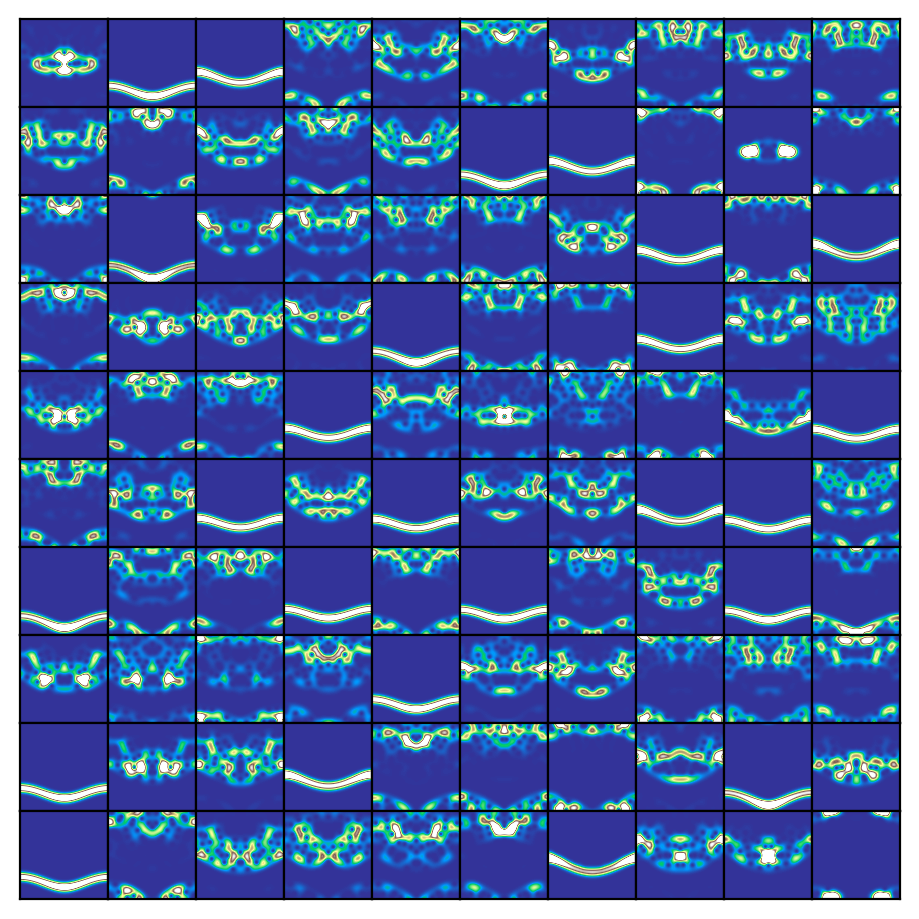

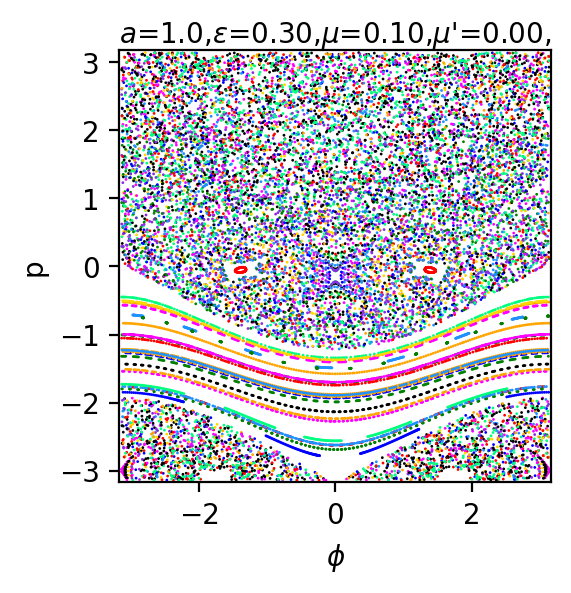

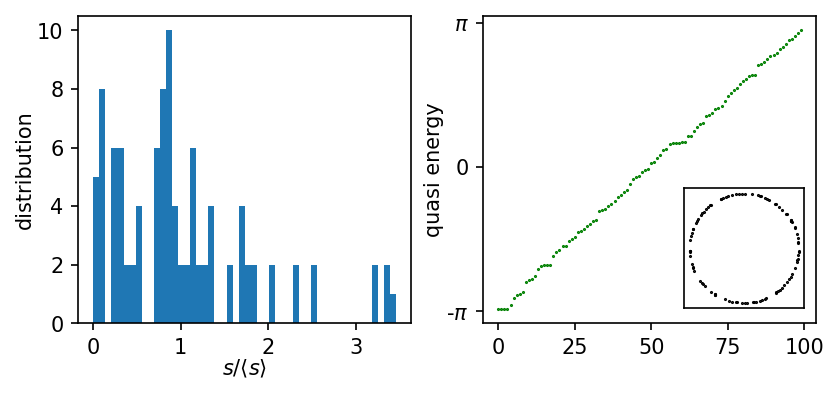

In [52]:
n=100; ntau=500; a = 1.0; eps = 0.3; mu = 0.10; mup=0.0; b=0
sim3= Hsys(n,ntau,a,b,eps,mu,mup,c_matrix_100)  # compute the propagator 
froot = 'awhole'
sim3.Hus(froot)
sim3.classical(froot)
sim3.circ(froot)